In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
import re
from collections import Counter

#download the Vader package
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df = pd.read_csv('./ufo_sighting_data_cleaned.csv')
df.head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brisson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,sighting_id,date_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,description,latitude,longitude,year,month,hour,season
0,0,1949-10-10 20:30:00,San Marcos,TX,US,Cylinder,2700,This event took place in early fall around 194...,29.883056,-97.941111,1949,10,20,Autumn
1,1,1949-10-10 21:00:00,Lackland Afb,TX,US,Light,7200,1949 Lackland AFB&#44 TX. Lights racing acros...,29.384210,-98.581082,1949,10,21,Autumn
2,2,1956-10-10 21:00:00,Edna,TX,US,Circle,20,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956,10,21,Autumn
3,3,1960-10-10 20:00:00,Kaneohe,HI,US,Light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960,10,20,Autumn
4,4,1961-10-10 19:00:00,Bristol,TN,US,Sphere,300,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,1961,10,19,Autumn
5,5,1965-10-10 23:45:00,Norwalk,CT,US,Disk,1200,A bright orange color changing to reddish colo...,41.117500,-73.408333,1965,10,23,Autumn
6,6,1966-10-10 20:00:00,Pell City,AL,US,Disk,180,Strobe Lighted disk shape object observed clos...,33.586111,-86.286111,1966,10,20,Autumn
7,7,1966-10-10 21:00:00,Live Oak,FL,US,Disk,120,Saucer zaps energy from powerline as my pregna...,30.294722,-82.984167,1966,10,21,Autumn
8,8,1968-10-10 13:00:00,Hawthorne,CA,US,Circle,300,ROUND &#44 ORANGE &#44 WITH WHAT I WOULD SAY W...,33.916389,-118.351667,1968,10,13,Autumn
9,9,1968-10-10 19:00:00,Brevard,NC,US,Fireball,180,silent red /orange mass of energy floated by t...,35.233333,-82.734444,1968,10,19,Autumn


<div style="font-size:20px;">
Witness Description Cleaning
</div>

In [41]:
#clean the description column to remove excess symbols/numbers/whitespace and words that do not convery meaning

def clean_text(comment_text):
    if pd.isna(comment_text):
        return comment_text  # keep Nan values
    # Remove symbols
    cleaned_text = re.sub(r'[@#$%^&*()_+{}[\]:;"\'<>,.~\\/\-|=]', '', comment_text)
    # Remove words that do not carry important info
    cleaned_text = re.sub(r'\b(?:and|is|in|the|on|of|to|for|a|i|my|was|at)\b', '', cleaned_text, flags=re.IGNORECASE)
    # Remove numbers
    cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)
    # Normalize whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # Remove special characters that appear between word characters
    cleaned_text = re.sub(r'(?<=\w)[^\w\s]+(?=\w)', '', cleaned_text)

    return cleaned_text.lower()

df['cleaned_description'] = df['description'].apply(clean_text)

<div style="font-size:20px;">
Word Cloud for Witness Description</div>

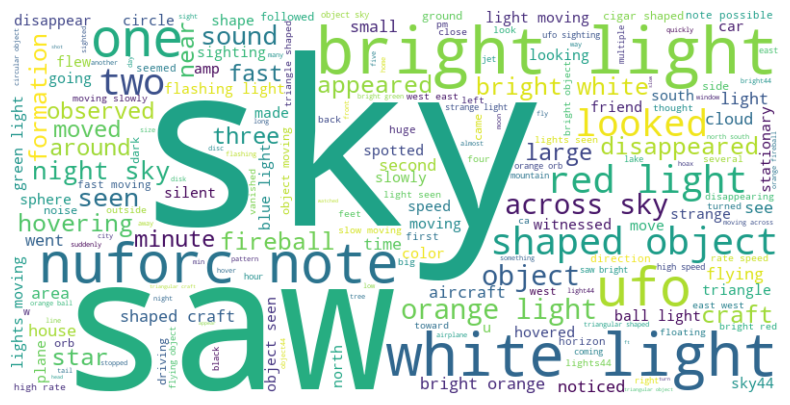

In [42]:
all_text = ' '.join(df['cleaned_description'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<div style="font-size:20px;">
Sentiment Analysis: Getting Sentiment Score from Vader Sentiment
</div>

In [43]:
def get_vader_sentiment(text):
    if pd.isna(text):
        return 0.0
    text = str(text)
    scores = analyzer.polarity_scores(text)
    #score will be from -1 (most negative) to +1 (most positive)
    return scores['compound']

df['sentiment_vader'] = df['cleaned_description'].apply(get_vader_sentiment)

<div style="font-size:20px;">
Most positive and negative descriptions
</div>

In [44]:
pd.set_option('display.max_colwidth', None)
print(df[['cleaned_description', 'sentiment_vader']].sort_values('sentiment_vader', ascending=False))
pd.reset_option('display.max_colwidth')

                                                                                                           cleaned_description  \
5841     ok didnt see it but heard about it hoping you could find out more friend told me that lastnight her friend seen craft   
68522  object looked liked star but it got so bright like it illuminated it scary44 it took like speed if sound44they are here   
38907                          visiting friends lawton everyone had gone bed sitting backyard relaxing enjoying clear warm nig   
49865          it very bright light kind like diamond ring glareing that did39nt blink44 ship diamond shaped made souring sort   
62288                                                  beautiful night44 clear skies wonderful light show hope see more future   
...                                                                                                                        ...   
67777                    this location not by choice but by accident this night became fig

<div style="font-size:20px;">
Kernel Density Estimate Distribution of Sentiment Scores
</div>

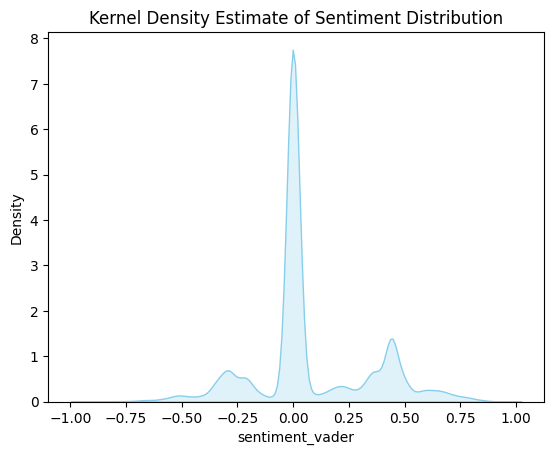

In [45]:
sns.kdeplot(df.sentiment_vader, fill=True, color='skyblue')
plt.title('Kernel Density Estimate of Sentiment Distribution')
plt.xlabel('sentiment_vader')
plt.ylabel('Density')
plt.show()

<div style="font-size:20px;">
Categorizing Witness Description as "Positive", "Neutral", "Negative"
</div>

In [46]:
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_vader'].apply(categorize_sentiment)

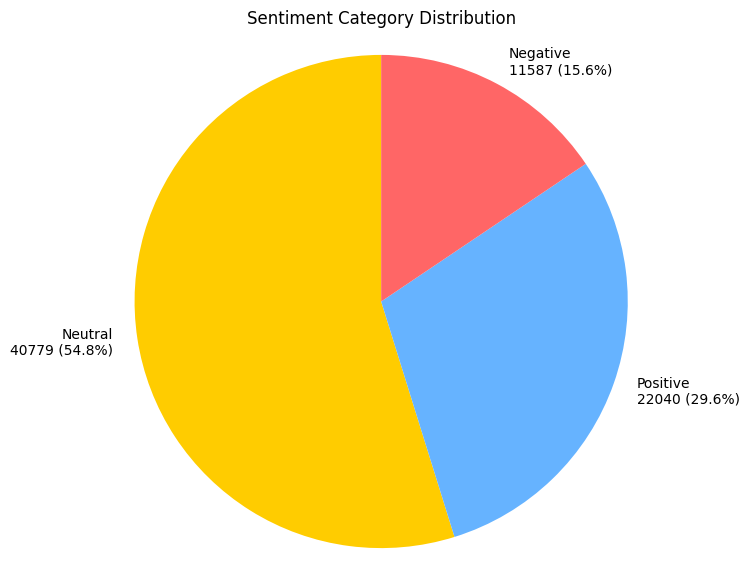

In [47]:
# Count the occurrences of each category
counts = df['sentiment_category'].value_counts()

percentages = counts / counts.sum() * 100

# # Create labels with count and percentage
labels = [f"{cat}\n{count} ({perc:.1f}%)" for cat, count, perc in zip(counts.index, counts.values, percentages.values)]

# # Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(counts, labels=labels, autopct='', startangle=90, colors=['#ffcc00', '#66b3ff', '#ff6666'])
plt.title('Sentiment Category Distribution')
plt.axis('equal')
plt.show()